# Glomerulus segmentation

## Preparation

### Imports and path

In [1]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random

For better reproducibility, we could have set random seeds and defined them here, but we only thought of this towards the end of the project, when most of the training sessions had already been run.

In [2]:
root_path = r'/scratch/cv-course2025/group9'
path_to_data = os.path.join(root_path, 'GlomDataset', 'GlomDataset')    # Double due to the nested folder structure

In [5]:
# Use CUDA device if available
print(f'CUDA available: {torch.cuda.is_available()}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA available: True


### GlomDataset class

In [4]:
class GlomDataset(Dataset):
    def __init__(self, path_to_data, mode, patch_size):
        """
        Parameters:
        path_to_data: Path to the dataset files as string. Should be top level folder containing 'train', 'test' and 'val' folders.
        mode: Either 'train', 'test' or 'validation' as string.
        """
        self.data = []
        self.masks = []
        self.patch_size = patch_size

        self.transform_img = T.Compose([
            T.Resize((patch_size, patch_size)), # resize to model input size
            T.ToTensor(),
            # The normalization step is legacy code that we unfortunately forgot to remove during the first
            # experiments. We had originally added it when planning to use a pre-trained encoder, but later
            # switched to training from scratch.
            # It was originally needed to match the input distribution expected by VGG16 trained on ImageNet. 
            # T.Normalize(mean=[0.485, 0.456, 0.406],
            #             std=[0.229, 0.224, 0.225])
            ])

        # Mask transform using resize and thresholding (255 → 1, 0 → 0)
        self.transform_mask = lambda mask: torch.from_numpy(
            (np.array(mask.resize((patch_size, patch_size), Image.NEAREST)) == 255).astype(np.uint8)
        ).long()

        #/.../GlomDataset
        mode_path = os.path.join(path_to_data, mode)
        if not os.path.exists(mode_path):
            raise FileNotFoundError(f"{mode_path} does not exist.")
        
        for desease in sorted(os.listdir(mode_path)):
            desease_path = os.path.join(mode_path, desease)
            for image in sorted(os.listdir(desease_path)):
                image_folder_path = os.path.join(desease_path, image)
                image_path = os.path.join(image_folder_path, 'img')
                mask_path = os.path.join(image_folder_path, 'mask')
        
                # Collect image files (assume images and masks have matching names)
                img_files = sorted(os.listdir(image_path))
                mask_files = sorted(os.listdir(mask_path))
        
                for img_file, mask_file in zip(img_files, mask_files):
                    self.data.append(os.path.join(image_path, img_file))
                    self.masks.append(os.path.join(mask_path, mask_file))

    # Lazy loading
    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert("RGB")
        mask = Image.open(self.masks[idx]).convert("L")  # grayscale mask

        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        
        return img, mask

    def __len__(self):
        return len(self.data)


In [5]:
# The patches in the GlomDataset are of size 2048x2048. Faster computation can be
# achieved by downsizing the patches with this parameter (e.g. to 256x256).
patch_size = 2048

# Load datasets
train_dataset = GlomDataset(path_to_data, 'train', patch_size)
val_dataset = GlomDataset(path_to_data, 'validation', patch_size)
test_dataset = GlomDataset(path_to_data, 'test', patch_size)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=1)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)


In [6]:
# We use this function when creating the dataloaders whenever we do not want to use the whole dataset.
def get_subset(dataset, subset_size=100):
    indices = random.sample(range(len(dataset)), subset_size)
    return Subset(dataset, indices)

### Variable UNet Architecture

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Two consecutive conv-batchnorm-ReLU blocks (standard in U-Net)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DilatedBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Split output channels across 3 parallel convolutions with increasing dilation
        part = out_channels // 3
        rest = out_channels - 2 * part

        self.dilated1 = nn.Conv2d(in_channels, part, 3, padding=1, dilation=1)
        self.dilated2 = nn.Conv2d(in_channels, part, 3, padding=2, dilation=2)
        self.dilated4 = nn.Conv2d(in_channels, rest, 3, padding=4, dilation=4)

        self.bn1 = nn.BatchNorm2d(part)
        self.bn2 = nn.BatchNorm2d(part)
        self.bn4 = nn.BatchNorm2d(rest)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Multi-scale feature extraction via dilated convolutions
        x1 = self.relu(self.bn1(self.dilated1(x)))
        x2 = self.relu(self.bn2(self.dilated2(x)))
        x3 = self.relu(self.bn4(self.dilated4(x)))
        return torch.cat([x1, x2, x3], dim=1)   # Concatenate along channel dimension


class VariableUNet(nn.Module):
    def __init__(self, patch_size: int):
        super().__init__()
        assert patch_size >= 256 and (patch_size % 16 == 0), "Patch size must be >= 256 and divisible by 16"

        # Scale channels based on patch size (reference is 2048 → 64) (256, 512, 1024: to little memory)
        scale = patch_size / 2048
        base = max(16, int(64 * scale))

        ch1, ch2, ch3, ch4 = base, base * 2, base * 4, base * 8
        
        # Encoder: downsampling path
        self.enc1 = DoubleConv(3, ch1)
        self.enc2 = DoubleConv(ch1, ch2)
        self.enc3 = DoubleConv(ch2, ch3)
        self.enc4 = DoubleConv(ch3, ch4)

        self.pool = nn.MaxPool2d(2)

        # Bottleneck: multi-scale context via dilated convolutions
        self.bottleneck = DilatedBottleneck(ch4, ch4)

        # Decoder: upsampling path with skip connections
        self.up4 = nn.ConvTranspose2d(ch4, ch3, 2, stride=2)
        self.dec4 = DoubleConv(ch4 + ch3, ch3)  # concat upsampled + skip connection

        self.up3 = nn.ConvTranspose2d(ch3, ch2, 2, stride=2)
        self.dec3 = DoubleConv(ch3 + ch2, ch2)

        self.up2 = nn.ConvTranspose2d(ch2, ch1, 2, stride=2)
        self.dec2 = DoubleConv(ch2 + ch1, ch1)

        self.up1 = nn.ConvTranspose2d(ch1, ch1 // 2, 2, stride=2)
        self.dec1 = DoubleConv(ch1 + (ch1 // 2), ch1 // 2)

        # Final 1×1 convolution to map to single-channel mask
        self.final = nn.Conv2d(ch1 // 2, 1, 1)

    def forward(self, x):
        assert x.shape[2] == x.shape[3], "Only square inputs supported"

        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder with skip connections
        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        # Output is raw logits. Therefore, we need to apply sigmoid during inference or use 
        # BCEWithLogitsLoss during training.
        return self.final(d1)


### Loss functions

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, dice_smooth=1e-5):
        super().__init__()
        self.smooth = dice_smooth

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        probs = probs.view(-1)
        targets = targets.view(-1)
        intersection = (probs * targets).sum()
        dice = (2. * intersection + self.smooth) / (probs.sum() + targets.sum() + self.smooth)
        return 1 - dice
        
# Noemie used the same with 0.8*BCE + 0.2*Dice
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.8, dice_smooth=1e-5, pos_weight=1.0):
        super().__init__()
        pos_weight_tensor = torch.tensor([pos_weight], device=device)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
        self.dice = DiceLoss(dice_smooth)
        self.bce_weight = bce_weight

    def forward(self, logits, targets):
        return self.bce_weight * self.bce(logits, targets) + (1 - self.bce_weight) * self.dice(logits, targets)


### Training loop

In [9]:
def train_model(model, train_dataloader, val_dataloader, config=None, output_dir='Output'):
    if config is None:
        raise ValueError("train_model() requires a config dictionary.")

    results_dir = os.path.join(output_dir, "Results")
    model_dir = os.path.join(output_dir, "Models")

    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    
    epochs = config['epochs']
    lr = config['lr']
    bce_weight = config['bce_weight']
    dice_smooth = config['dice_smooth']
    pos_weight = config['pos_weight']

    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_recall': [],
        'val_precision': [],
        'val_f1_score': []
    }

    criterion = BCEDiceLoss(bce_weight, dice_smooth, pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Training", unit="batch")

        for i, (imgs, masks) in enumerate(pbar):
            imgs, masks = imgs.to(device), masks.to(device)
            masks = masks.unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            with torch.no_grad():
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5)
                correct_pixels += (preds == masks.bool()).sum().item()
                total_pixels += masks.numel()

            # Update progress bar
            if (i + 1) % 10 == 0:
                pbar.set_postfix({'Loss': f'{running_loss / (i + 1):.4f}'})

        # Calculate training metrics
        train_avg_loss = running_loss / len(train_dataloader)
        train_accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_pixels = 0
        val_total_pixels = 0
        
        val_TP, val_FP, val_FN = 0, 0, 0

        with torch.no_grad():
            val_pbar = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Validation", unit="batch")
            
            for imgs, masks in val_pbar:
                imgs, masks = imgs.to(device), masks.to(device)
                masks = masks.unsqueeze(1).float()
                
                outputs = model(imgs)
                val_loss = criterion(outputs, masks)
                
                val_running_loss += val_loss.item()
                
                # Compute validation accuracy
                preds = torch.sigmoid(outputs) > 0.5
                val_correct_pixels += (preds == masks).sum().item()
                val_total_pixels += masks.numel()

                pred = preds.bool()
                true = masks.bool() 

                val_TP += (pred & true).sum().item()
                val_FP += (pred & (~true)).sum().item()
                val_FN += ((~pred) & true).sum().item()     
                
                # Update validation progress bar
                val_pbar.set_postfix({'Val Loss': f'{val_loss.item():.4f}'})

        # Calculate validation metrics
        val_avg_loss = val_running_loss / len(val_dataloader)
        val_accuracy = val_correct_pixels / val_total_pixels if val_total_pixels > 0 else 0

        epsilon = 1e-8
        precision = val_TP / (val_TP + val_FP + epsilon)
        recall = val_TP / (val_TP + val_FN + epsilon)
        f1 = 2 * precision * recall / (precision + recall + epsilon)
        
        # Store metrics in history
        history['train_loss'].append(train_avg_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_avg_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_recall'].append(recall)
        history['val_precision'].append(precision)
        history['val_f1_score'].append(f1)

        # End-of-epoch logging
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train - Loss: {train_avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        print(f"  Val   - Loss: {val_avg_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        print(f"  Val   - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print("-" * 50)

    # Save results and model
    save_results(history, model, config, results_dir, model_dir)


def save_results(history, model, config, results_dir, model_dir):
    # Save training history and config
    suffix = (
        f"ps{config['patch_size']}_po{config['patch_overlap']}_ep{config['epochs']}"
        f"_bs{config['batch_size']}_lr{str(config['lr']).replace('.', 'p')}"
        f"_bceW{str(config['bce_weight']).replace('.', 'p')}"
        f"_ds{str(config['dice_smooth']).replace('.', 'p')}"
        f"_posW{str(config['pos_weight']).replace('.', 'p')}"
    )

    results_path = os.path.join(results_dir, f"{suffix}.json")
    model_path = os.path.join(model_dir, f"{suffix}.pth")

    with open(results_path, 'w') as f:
        json.dump({'config': config, 'history': history}, f, indent=4)
        
    torch.save(model.state_dict(), model_path)

In [11]:
def run_experiments(train_dataloader, val_dataloader, output_dir, patch_size=2048, batch_size=16, patch_overlap=0,
                    epochs=10, lrs=[1e-4], bce_weights=[0.8], dice_smooths=[1e-5], pos_weights=[1.0]):
    for lr in lrs:
        for bce_weight in bce_weights:
            for dice_smooth in dice_smooths:
                for pos_weight in pos_weights:
                    model = VariableUNet(patch_size).to(device)
    
                    config = {
                        'patch_size': patch_size,
                        'batch_size': batch_size,
                        'patch_overlap': patch_overlap,
                        'epochs': epochs,
                        'lr': lr,
                        'bce_weight': bce_weight,
                        'dice_smooth': dice_smooth,
                        'pos_weight': pos_weight
                    }
    
                    print(f"Starting training with config: {config}")
    
                    train_model(
                        model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        config=config,
                        output_dir=output_dir
                    )


### Evaluation and Visualisation

In [ ]:
def read_json_files_in_folder(folder_path):
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    data = []
    for file in json_files:
        try:
            with open(os.path.join(folder_path, file), 'r') as f:
                content = json.load(f)
                content['filename'] = file  # track source file
                data.append(content)
        except Exception as e:
            print(f"Warning: Failed to read {file} — {e}")
    return data

def plot_top_models_by_metric(
    folder_path,
    metric='f1_score',
    additional_metrics=None,
    filter_min_recall=0.5,
    top_n=5
):
    if additional_metrics is None:
        additional_metrics = []

    json_data = read_json_files_in_folder(folder_path)

    # Filter by recall threshold
    filtered_data = [
        x for x in json_data
        if x.get("history", {}).get("recall") and x["history"]["recall"][-1] >= filter_min_recall
    ]

    if not filtered_data:
        print("No models passed the filtering criteria.")
        return

    # Sort by final value of main metric
    sorted_data = sorted(
        filtered_data,
        key=lambda x: x["history"].get(metric, [0])[-1],
        reverse=True
    )

    top_models = sorted_data[:top_n]

    plt.figure(figsize=(12, 7))

    for data in top_models:
        history = data['history']
        y_main = history.get(metric, [])
        epochs = range(1, len(y_main) + 1)

        label_base = data['filename'].replace('.json', '')
        line, = plt.plot(
            epochs,
            y_main,
            linewidth=2,
            label=f"{metric} - {label_base}"
        )

        # Optional: plot additional metrics in dashed lines
        for add_metric in additional_metrics:
            y_add = history.get(add_metric, [])
            if y_add:
                plt.plot(
                    epochs,
                    y_add,
                    linestyle='--',
                    linewidth=2,
                    color=line.get_color(),
                    label=f"{add_metric} - {label_base}"
                )

    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title(f"Top {top_n} Models by Final {metric} (Recall ≥ {filter_min_recall})",
              fontsize=14, fontweight='bold')
    plt.legend(loc='best', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    plot_name = f"top{top_n}_{metric}_recall{int(filter_min_recall * 100)}.png"
    plt.savefig(os.path.join(folder_path, plot_name), dpi=300)
    plt.show()


In [ ]:
def plot_training_history(history, save_dir, filename='training_plot.png'):
    epochs = range(1, len(history.get('loss', [])) + 1)

    if not epochs:
        print("No loss data found — skipping plot.")
        return

    plt.figure(figsize=(10, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    if 'loss' in history:
        plt.plot(epochs, history['loss'], 'b-', label='Training Loss')
    else:
        print("Warning: 'loss' key not found in history.")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    has_any_acc = False
    if 'accuracy' in history:
        plt.plot(epochs, history['accuracy'], 'g-', label='Train Acc')
        has_any_acc = True
    if 'val_accuracy' in history:
        plt.plot(epochs, history['val_accuracy'], 'r--', label='Val Acc')
        has_any_acc = True

    if has_any_acc:
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy over Epochs')
        plt.grid(True)
        plt.legend()
    else:
        plt.title("No Accuracy Data")

    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    plt.close()


In [ ]:
def test_model(model, test_dataloader, config, results_dir, device=device):
    bce_weight = config['bce_weight']               
    dice_smooth = config['dice_smooth']             
    pos_weight = config['pos_weight']               
    
    criterion = BCEDiceLoss(bce_weight, dice_smooth, pos_weight)    
    
    running_loss = 0
    correct_pixels = 0
    total_pixels = 0
    TP = FP = FN = 0

    with torch.no_grad(): 
        pbar = tqdm(test_dataloader, desc="Test", unit="batch")
        
        for imgs, masks in pbar:
            imgs, masks = imgs.to(device), masks.to(device)
            masks = masks.unsqueeze(1).float()      

            outputs = model(imgs)
            test_loss = criterion(outputs, masks)   

            running_loss += test_loss.item()   

            # Compute test accuracy
            preds = torch.sigmoid(outputs) > 0.5
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

            pred = preds.bool()
            true = masks.bool() 

            TP += (pred & true).sum().item()
            FP += (pred & (~true)).sum().item()
            FN += ((~pred) & true).sum().item()

            # Update progress bar
            pbar.set_postfix({'Test Loss': f'{test_loss.item():.4f}'})   

    # Calculate test metrics
    avg_loss = running_loss / len(test_dataloader)                  
    accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0  

    epsilon = 1e-8
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    dice_score = 2 * TP / (2 * TP + FP + FN + epsilon)

    print("Test metrics:")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Dice Score: {dice_score:.4f}")

    test_metrics = {
        'loss': avg_loss,                           
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'dice_score': dice_score,
    }

    # Save test metrics and config
    suffix = (
        f"ps{config['patch_size']}_po{config['patch_overlap']}_ep{config['epochs']}"
        f"_bs{config['batch_size']}_lr{str(config['lr']).replace('.', 'p')}"
        f"_bceW{str(config['bce_weight']).replace('.', 'p')}"
        f"_ds{str(config['dice_smooth']).replace('.', 'p')}"
        f"_posW{str(config['pos_weight']).replace('.', 'p')}"
    )

    results_path = os.path.join(results_dir, f"test_metrics_{suffix}.json")
    os.makedirs(results_dir, exist_ok=True)

    with open(results_path, 'w') as f:
        json.dump({'config': config, 'test_metrics': test_metrics}, f, indent=4)


In [7]:
def visualize_model_predictions(model_path, root_path, path_to_data, device, num_images=5, shuffle=False):
    print(f"\nLoading model: {model_path}")

    # Load config
    config_path = model_path.replace('Models', 'Results').replace('.pth', '.json')
    with open(os.path.join(root_path, config_path), 'r') as f:
        config = json.load(f)['config']

    patch_size = config['patch_size']
    model = VariableUNet(patch_size)
    model.load_state_dict(torch.load(os.path.join(root_path, model_path), map_location=device))
    model.to(device)
    model.eval()

    # Load dataset matching the model's patch size
    dataset = GlomDataset(path_to_data, 'test', patch_size)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=shuffle)
    
    shown = 0
    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            masks = masks.unsqueeze(1).float()

            outputs = model(imgs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            for i in range(imgs.size(0)):
                if shown >= num_images:
                    return
                if masks[i].sum() == 0:
                    continue

                img_np = imgs[i].cpu().permute(1, 2, 0).numpy()
                gt_mask = masks[i][0].cpu().numpy()
                pred_mask = preds[i][0].cpu().numpy()

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(img_np)
                axes[0].set_title("Image")
                axes[1].imshow(gt_mask, cmap="gray")
                axes[1].set_title("Ground Truth")
                axes[2].imshow(pred_mask, cmap="gray")
                axes[2].set_title("Prediction")

                for ax in axes:
                    ax.axis('off')
                plt.tight_layout()
                plt.suptitle(f"Model: {os.path.basename(model_path)}", fontsize=14)
                plt.subplots_adjust(top=0.85)
                plt.show()

                shown += 1

def run_all_models(models_dir, root_path, path_to_data, device, num_images=5, shuffle=False):
    model_files = sorted([
        os.path.join(models_dir, f) for f in os.listdir(models_dir)
        if f.endswith(".pth")
    ])

    if not model_files:
        print("No model files found in:", models_dir)
        return

    for model_path in model_files:
        visualize_model_predictions(model_path, root_path, path_to_data, device, num_images=num_images, shuffle=shuffle)


## Data exploration

Are there any patches that do not contain any glomeruli?

In [17]:
def count_empty_imgs(dataloader):
    total_empty = 0

    for imgs, masks in tqdm(dataloader, desc="Counting Empty"):
        # No gradients needed
        with torch.no_grad():
            # Convert masks to binary (0 or 1), if not already
            masks = masks.float()  # or .long() if needed
            total_pos = (masks == 1).sum().item()

            if(total_pos == 0):
                total_empty += 1

    return total_empty

print(f"Total patches: {len(train_dataloader)}")
print(f"Empty patches: {count_empty_imgs(train_dataloader) / len(train_dataloader)}%")

Total patches: 5331


Counting Empty: 100%|███████████████████| 5331/5331 [03:38<00:00, 24.38it/s]

Empty patches: 0.0%


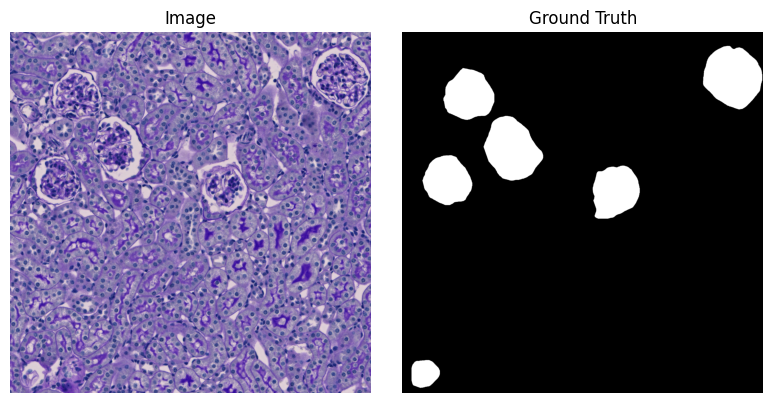

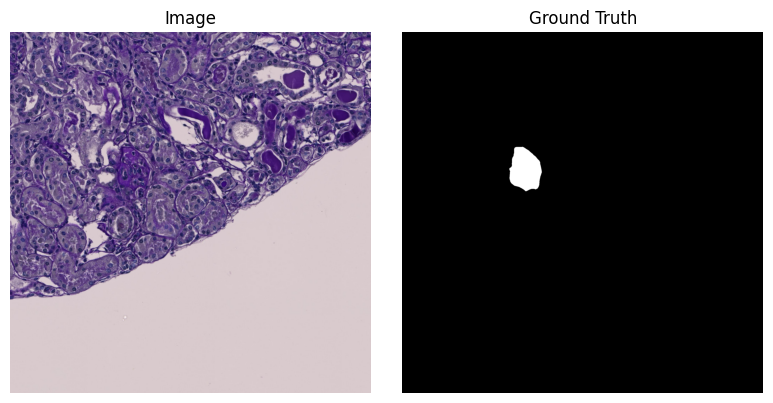

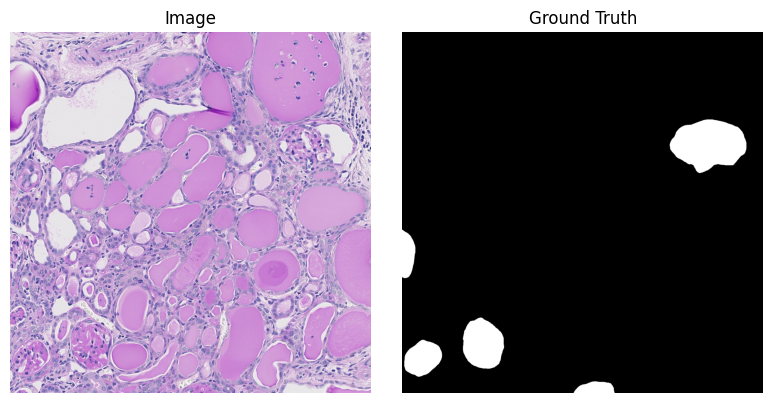

In [18]:
def show_non_empty_samples(dataset, max_images=3):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    
    shown = 0

    for i in indices:
        img, mask = dataset[i]

        if mask.sum() == 0:
            continue  # Skip empty masks

        # Convert to NumPy for display
        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.squeeze().numpy()

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(img_np)
        axs[0].set_title("Image")
        axs[0].axis("off")
        axs[1].imshow(mask_np, cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[1].axis("off")
        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= max_images:
            break

show_non_empty_samples(train_dataset)

The fact that the ground truth masks are very unbalanced in terms of the number of black and white pixels, as the background is much larger than the areas occupied by glomeruli, could be an aggravating factor during training. Therefore, to prevent us from learning only the majority baseline (all black/background), we want to test the more weighted penalization of false negative pixels in the binary cross entropy (BCE) loss function. To have an indication of how much we should penalize false negative predicted pixels, we examine how many more black pixels there are compared to white pixels on the training dataset.

In [19]:
def compute_class_pixel_stats(dataloader):
    total_pos = 0
    total_neg = 0

    for imgs, masks in tqdm(dataloader, desc="Counting pixels"):
        # No gradients needed for read-only operation
        with torch.no_grad():
            # Convert masks to binary (0 or 1), if not already
            masks = masks.float()
            total_pos += (masks == 1).sum().item()
            total_neg += (masks == 0).sum().item()

    return total_pos, total_neg

pos_pixels, neg_pixels = compute_class_pixel_stats(train_dataloader)
pos_weight_value = neg_pixels / (pos_pixels + 1e-6) 

pos_weight = torch.tensor([pos_weight_value]).to(device)
print(pos_weight)
# tensor([23.3834], device='cuda:0')

Counting pixels: 100%|██████████████████| 5331/5331 [04:45<00:00, 18.67it/s]


tensor([23.3834], device='cuda:0')


## Experiment 0: How we started

Our first training attempts began after discarding a VGG16-based encoder, which we had originally considered using with pretrained ImageNet weights. We opted instead to train the model from scratch for greater flexibility. However, we accidentally retained a legacy normalization step in the data preprocessing pipeline, which had been tailored for the VGG encoder. This normalization remained in the `GlomDataset` class (see the corresponding comment there) throughout our early experiments and may have influenced input scaling.  

We started with a BCE loss, but the model did not learn meaningful segmentation. Switching to a combination of BCE and Dice loss also failed to yield improvements. Eventually, we discovered a critical bug in our pipeline: the DataLoader was mismatching images and masks due to inconsistent file ordering. Fixing this issue allowed the model to start identifying glomeruli structures.  

Nevertheless, the model often defaulted to predicting only background (i.e., no glomeruli), resulting in superficially high accuracy (~96%) due to class imbalance (on average, the ratio of background to foreground pixels in the masks was 23.38:1).  This prompted us to later experiment with `pos_weight` to penalize false negatives more heavily.

To explore architecture scaling, we experimented with different input patch sizes (256, 512, 1024) by modifying the following lines in the `VariableUNet` class:
```
scale = patch_size / 2048
base = max(16, int(64 * scale))
```
These variations were intended to scale the number of channels in the U-Net relative to the input patch size. However, when using a reference patch size (i.e., the denominator in the scale calculation) smaller than 2048, training on full-size 2048×2048 patches led to out-of-memory errors — even with `batch_size=1` on our Nvidia A30 GPU. The reason is that a small reference value caused a disproportionately large scale, which in turn led to excessive upscaling of the number of channels throughout the network. Setting the reference patch size to 2048 allowed training to proceed without memory issues.  

This phase established a working architecture and data pipeline, enabling us to conduct the following experiments.

## Experiment 1: Hyperparameter tuning

To keep computational costs manageable during extensive hyperparameter tuning, we trained all configurations in this experiment on a reduced subset of the dataset: 700 training samples and 50 validation samples.

In [ ]:
# Create output directory
output_dir = os.path.join(root_path, 'Experiment1')
os.makedirs(output_dir, exist_ok=True)

# Subsets
train_dataloader_700 = DataLoader(get_subset(train_dataset, 700), shuffle=True, batch_size=1)
val_dataloader_50 = DataLoader(get_subset(val_dataset, 50), shuffle=False, batch_size=1)

run_experiments(
    train_dataloader=train_dataloader_700,
    val_dataloader=val_dataloader_50,
    output_dir=output_dir,
    patch_size=2048,
    patch_overlap=0,
    epochs=5,
    batch_size=16,
    lrs=[1e-3],
    bce_weights=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    dice_smooths=[1e-4, 1e-5, 1e-6],
    pos_weights=[1, 5, 10, 25]
)

## Experiment 2: Continued hyperparameter tuning

We chose the most promising `dice_smooth` value from experiment 1 and decided to further investigate the effects of `bce_weight` and `pos_weight` by narrowing their ranges and testing combinations that had shown potential in the previous run.

In [ ]:
output_dir = os.path.join(root_path, 'Experiment2')
os.makedirs(output_dir, exist_ok=True)

# Subsets
train_dataloader_700 = DataLoader(get_subset(train_dataset, 700), shuffle=True, batch_size=1)
val_dataloader_50 = DataLoader(get_subset(val_dataset, 50), shuffle=False, batch_size=1)

run_experiments(
    train_dataloader=train_dataloader_700,
    val_dataloader=val_dataloader_50,
    output_dir=output_dir,
    patch_size=2048,
    patch_overlap=0,
    epochs=5,
    batch_size=16,
    lrs=[1e-3],
    dice_smooths=[1e-6],    # now fixed
    bce_weights=[0.55, 0.6, 0.65],
    pos_weights=[13, 17, 21, 25]
)


## Experiment 3: Training with two promising hyperparameter selections on full dataset

These were two of the best models from the previous run (experiment 2). We selected them for full training on the entire dataset, increasing the number of epochs to assess their performance under more realistic training conditions.

In [ ]:
output_dir = os.path.join(root_path, 'Experiment3')
os.makedirs(output_dir, exist_ok=True)

patch_size = 2048
batch_size = 16
patch_overlap = 0
epochs = 10
lr = 1e-3

config = {
    'patch_size': patch_size,
    'batch_size': batch_size,
    'patch_overlap': patch_overlap,
    'epochs': epochs,
    'lr': lr,
    'bce_weight': 0.6,
    'dice_smooth': 1e-6,
    'pos_weight': 25
}

model = VariableUNet(patch_size).to(device)
train_model(model, train_dataloader, val_dataloader, config=config, output_dir=output_dir)


config = {
    'patch_size': patch_size,
    'batch_size': batch_size,
    'patch_overlap': patch_overlap,
    'epochs': epochs,
    'lr': lr,
    'bce_weight': 0.65,
    'dice_smooth': 1e-6,
    'pos_weight': 13
}

model = VariableUNet(patch_size).to(device)
train_model(model, train_dataloader, val_dataloader, config=config, output_dir=output_dir)


Unfortunately, the results were disappointing. After 20 epochs of training on the full training set, both models appeared to regress toward the majority baseline — predicting mostly background. This led us to re-examine the pipeline for potential errors or optimization opportunities.

During this review, we noticed a legacy normalization step still present in the GlomDataset class — originally intended for use with the discarded VGG16 encoder (as already discussed in the report on experiment 0). Although this step should no longer have been applied, a quick cross-check showed that it fortunately had not significantly harmed model performance. Nevertheless, we removed this normalization from all subsequent experiments.

We also realized that, contrary to what is now shown in the current version of this notebook, we had not explicitly set the learning rate for the Adam optimizer in earlier experiments. While our intention had been to use a learning rate of `1e-4`, this line had apparently been commented out, causing Adam to default to `1e-3`. Suspecting that this might be too high, we decided to explore smaller learning rates going forward.

## Experiment 4: Hyperparameter tuning, again

To speed up further experimentation, we began running hyperparameter tuning on downscaled patches (`patch_size=256`). To keep training time efficient, all models in this experiment were trained on subsets of the dataset (either 500 or 2000 training samples and 50 or 100 validation samples).

Based on the promising results from experiments 1 and 2, we focused on `bce_weight` values around 0.6 and 0.8, `pos_weight` values between 10 and 25, and further explored the effects of lower `dice_smooth` values.
Unlike previous experiments, we now explicitly used smaller learning rates (`1e-5` and `1e-4`) instead of relying on Adam’s default `lr` of `1e-3`.  

In addition, we included a targeted run with a higher dice_smooth of `1e-3` to cover a previously missing configuration.

In [ ]:
# Subsets
train_dataloader_2000 = DataLoader(get_subset(train_dataset, 2000), shuffle=True, batch_size=1)
val_dataloader_100 = DataLoader(get_subset(val_dataset, 100), shuffle=False, batch_size=1)

train_dataloader_500 = DataLoader(get_subset(train_dataset, 500), shuffle=True, batch_size=1)
val_dataloader_50 = DataLoader(get_subset(val_dataset, 50), shuffle=False, batch_size=1)

output_dir = os.path.join(root_path, 'Experiment4')
os.makedirs(output_dir, exist_ok=True)

run_experiments(
    train_dataloader=train_dataloader_2000,
    val_dataloader=val_dataloader_100,
    output_dir=output_dir,
    patch_size=256,
    patch_overlap=0,
    epochs=20,
    batch_size=16,
    lrs=[1e-5, 1e-4],
    bce_weights=[0.6, 0.8],
    dice_smooths=[1e-6, 1e-5],
    pos_weights=[10, 15, 20, 25]
)

run_experiments(
    train_dataloader=train_dataloader_500,
    val_dataloader=val_dataloader_50,
    output_dir=output_dir,
    patch_size=256,
    patch_overlap=0,
    epochs=20,
    batch_size=16,
    lrs=[1e-5],
    bce_weights=[0.6],
    dice_smooths=[1e-3],
    pos_weights=[20]
)

## Experiment 5: Training with promising hyperparameter selection on full dataset

Based on the best-performing hyperparameter configuration from the previous experiments, we now train a single model on the entire training dataset with the full `patch_size` of `2048` to further validate and refine our results.

In [ ]:
output_dir = os.path.join(root_path, 'Experiment5')
os.makedirs(output_dir, exist_ok=True)

run_experiments(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    output_dir=output_dir,
    patch_size=2048,
    patch_overlap=0,
    epochs=20,
    batch_size=16,
    lrs=[1e-4],
    dice_smooths=[1e-6],
    bce_weights=[0.8],
    pos_weights=[25]
)


Starting training with config: {'patch_size': 2048, 'batch_size': 16, 'patch_overlap': 0, 'epochs': 20, 'lr': 0.0001, 'bce_weight': 0.8, 'dice_smooth': 1e-06, 'pos_weight': 25}


Epoch [1/20] Training:   9%| | 463/5331 [04:40<49:08,  1.65batch/s, Loss=0.8

In [8]:
visualize_model_predictions(os.path.join('Experiment5', 'Models', 'ps2048_po0_ep20_bs16_lr0p0001_bceW0p8_ds1e-06_posW25.pth'), root_path, path_to_data, device, num_images=5, shuffle=False)

## Model Evaluation

In [ ]:
# Old paths. Will be cleaned up later.
model_paths = [
    'Experiment5/Models/ps2048_po0_ep20_bs16_lr0p0001_bceW0p8_ds1e-06_posW25.pth',
    'Experiment4/Models/ps256_po0_ep20_bs16_lr0p0001_bceW0p8_ds1e-06_posW25.pth',
    'Experiment3/Models/ps2048_po0_ep10_bs16_lr0p0001_bceW0p6_ds1e-06_posW25.pth',
    'Experiment3/Models/ps2048_po0_ep10_bs16_lr0p0001_bceW0p65_ds1e-06_posW13.pth',
    'Experiment2/Models/ps2048_po0_ep5_bs16_lr0p0001_bceW0p6_ds1e-06_posW25.pth',
    'Experiment2/Models/ps2048_po0_ep5_bs16_lr0p0001_bceW0p65_ds1e-06_posW13.pth', 
]

for model_path in model_paths:
    # Parse model directory and filename
    model_dir, model_file = os.path.split(model_path)
    results_dir = model_dir.replace('Models', 'Results')
    results_json = model_file.replace('.pth', '.json')
    
    # Load config
    with open(os.path.join(root_path, results_dir, results_json), 'r') as f:
        config = json.load(f)['config']
    
    # Load model
    model = VariableUNet(config['patch_size'])
    model.load_state_dict(torch.load(os.path.join(root_path, model_path), map_location=device))
    model.to(device)
    model.eval()

    # Load test data
    testing_dataset = GlomDataset(path_to_data, 'test', config['patch_size'])
    testing_dataloader = DataLoader(get_subset(testing_dataset, 10), shuffle=False, batch_size=1)

    # Define result output location (e.g. for evaluation results)
    eval_results_dir = os.path.join(root_path, 'Model_Evaluation')
    os.makedirs(eval_results_dir, exist_ok=True)

    test_model(model=model,
               test_dataloader=testing_dataloader,
               config=config,
               results_dir=eval_results_dir,
               device=device)

## Cross-Dataset Generalization: Evaluation on PanNuke

To evaluate the cross-dataset generalization capability of our model, we train it on the PanNuke dataset using the same hyperparameters as in the previous section. Since PanNuke images are only 256×256 pixels in size, we adjust the `patch_size` accordingly.

In [12]:
class PannukeBinaryDataset(Dataset):
    def __init__(self, path, folds):
        self.imgs = []
        self.masks = []
        self.types = []
        self.lengths = []

        for fold in folds:
            # Upper folder is named "Fold 1" and lower folder "fold1"
            fold_clean = fold.lower().replace(" ", "")
            fold_path = os.path.join(path, fold)
            images_path = os.path.join(fold_path, 'images', fold_clean, 'images.npy')
            types_path = os.path.join(fold_path, 'images', fold_clean, 'types.npy')
            masks_path = os.path.join(fold_path, 'masks', fold_clean, 'masks.npy')
            
            # Load .npy files using memory mapping
            imgs = np.load(images_path, mmap_mode='r')
            msks = np.load(masks_path, mmap_mode='r')
            tps = np.load(types_path, mmap_mode='r')

            self.imgs.append(imgs)
            self.masks.append(msks)
            self.types.append(tps)
            self.lengths.append(len(imgs))

        self.cum_lengths = np.cumsum([0] + self.lengths)

    def __getitem__(self, idx):
        fold_idx = np.searchsorted(self.cum_lengths, idx, side='right') - 1
        local_idx = idx - self.cum_lengths[fold_idx]

        # Normalize image
        img = self.imgs[fold_idx][local_idx].astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # (C, H, W)

        # Convert multi-channel mask to binary mask
        mask = self.masks[fold_idx][local_idx].astype(np.float32)
        foreground_mask = mask[..., :-1]  # Drop background channel
        foreground_mask = (foreground_mask > 0).astype(np.float32)
        mask = np.max(foreground_mask, axis=2, keepdims=True)  # (H, W, 1)
        mask = np.transpose(mask, (2, 0, 1))  # (1, H, W)

        return torch.from_numpy(img), torch.from_numpy(mask)

    def __len__(self):
        return sum(self.lengths)


In [15]:
def train_model_pannuke(model, train_dataloader, val_dataloader, config=None, output_dir='Output'):
    if config is None:
        raise ValueError("train_model() requires a config dictionary.")

    results_dir = os.path.join(output_dir, "Results")
    model_dir = os.path.join(output_dir, "Models")

    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    
    epochs = config['epochs']
    lr = config['lr']
    bce_weight = config['bce_weight']
    dice_smooth = config['dice_smooth']
    pos_weight = config['pos_weight']

    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_recall': [],
        'val_precision': [],
        'val_f1_score': []
    }

    criterion = BCEDiceLoss(bce_weight, dice_smooth, pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Training", unit="batch")

        for i, (imgs, masks) in enumerate(pbar):
            imgs, masks = imgs.to(device), masks.to(device)
            #masks = masks.unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            with torch.no_grad():
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5)
                correct_pixels += (preds == masks.bool()).sum().item()
                total_pixels += masks.numel()

            # Update progress bar
            if (i + 1) % 10 == 0:
                pbar.set_postfix({'Loss': f'{running_loss / (i + 1):.4f}'})

        # Calculate training metrics
        train_avg_loss = running_loss / len(train_dataloader)
        train_accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_pixels = 0
        val_total_pixels = 0
        
        val_TP, val_FP, val_FN = 0, 0, 0

        with torch.no_grad():
            val_pbar = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Validation", unit="batch")
            
            for imgs, masks in val_pbar:
                imgs, masks = imgs.to(device), masks.to(device)
                #masks = masks.unsqueeze(1).float()
                
                outputs = model(imgs)
                val_loss = criterion(outputs, masks)
                
                val_running_loss += val_loss.item()
                
                # Compute validation accuracy
                preds = torch.sigmoid(outputs) > 0.5
                val_correct_pixels += (preds == masks).sum().item()
                val_total_pixels += masks.numel()

                pred = preds.bool()
                true = masks.bool() 

                val_TP += (pred & true).sum().item()
                val_FP += (pred & (~true)).sum().item()
                val_FN += ((~pred) & true).sum().item()     
                
                # Update validation progress bar
                val_pbar.set_postfix({'Val Loss': f'{val_loss.item():.4f}'})

        # Calculate validation metrics
        val_avg_loss = val_running_loss / len(val_dataloader)
        val_accuracy = val_correct_pixels / val_total_pixels if val_total_pixels > 0 else 0

        epsilon = 1e-8
        precision = val_TP / (val_TP + val_FP + epsilon)
        recall = val_TP / (val_TP + val_FN + epsilon)
        f1 = 2 * precision * recall / (precision + recall + epsilon)
        
        # Store metrics in history
        history['train_loss'].append(train_avg_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_loss'].append(val_avg_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_recall'].append(recall)
        history['val_precision'].append(precision)
        history['val_f1_score'].append(f1)

        # End-of-epoch logging
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"  Train - Loss: {train_avg_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        print(f"  Val   - Loss: {val_avg_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        print(f"  Val   - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print("-" * 50)

    # Save results and model
    save_results(history, model, config, results_dir, model_dir)


def save_results(history, model, config, results_dir, model_dir):
    # Save training history and config
    suffix = (
        f"ps{config['patch_size']}_po{config['patch_overlap']}_ep{config['epochs']}"
        f"_bs{config['batch_size']}_lr{str(config['lr']).replace('.', 'p')}"
        f"_bceW{str(config['bce_weight']).replace('.', 'p')}"
        f"_ds{str(config['dice_smooth']).replace('.', 'p')}"
        f"_posW{str(config['pos_weight']).replace('.', 'p')}"
    )

    results_path = os.path.join(results_dir, f"{suffix}.json")
    model_path = os.path.join(model_dir, f"{suffix}.pth")

    with open(results_path, 'w') as f:
        json.dump({'config': config, 'history': history}, f, indent=4)
        
    torch.save(model.state_dict(), model_path)

In [17]:
def run_experiments_pannuke(train_dataloader, val_dataloader, output_dir, patch_size=2048, batch_size=16, patch_overlap=0,
                    epochs=10, lrs=[1e-4], bce_weights=[0.8], dice_smooths=[1e-5], pos_weights=[1.0]):
    for lr in lrs:
        for bce_weight in bce_weights:
            for dice_smooth in dice_smooths:
                for pos_weight in pos_weights:
                    model = VariableUNet(patch_size).to(device)
    
                    config = {
                        'patch_size': patch_size,
                        'batch_size': batch_size,
                        'patch_overlap': patch_overlap,
                        'epochs': epochs,
                        'lr': lr,
                        'bce_weight': bce_weight,
                        'dice_smooth': dice_smooth,
                        'pos_weight': pos_weight
                    }
    
                    print(f"Starting training with config: {config}")
    
                    train_model_pannuke(
                        model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        config=config,
                        output_dir=output_dir
                    )


In [18]:
output_dir = os.path.join(root_path, 'CrossDataset_Experiment_PanNuke')
os.makedirs(output_dir, exist_ok=True)

path_to_pannuke = r'/scratch/cv-course2025/pannuke'

# Load datasets
pannuke_train_dataset = PannukeBinaryDataset(path_to_pannuke, ["Fold 1", "Fold 2"])
pannuke_val_dataset = PannukeBinaryDataset(path_to_pannuke, ["Fold 3"])

# Create dataloaders
pannuke_train_dataloader = DataLoader(pannuke_train_dataset, shuffle=True, batch_size=1)
pannuke_val_dataloader = DataLoader(pannuke_val_dataset, shuffle=False, batch_size=1)

run_experiments_pannuke(
    train_dataloader=pannuke_train_dataloader,
    val_dataloader=pannuke_val_dataloader,
    output_dir=output_dir,
    patch_size=256,
    patch_overlap=0,
    epochs=20,
    batch_size=16,
    lrs=[1e-4],
    dice_smooths=[1e-6],
    bce_weights=[0.8],
    pos_weights=[25]
)


Starting training with config: {'patch_size': 256, 'batch_size': 16, 'patch_overlap': 0, 'epochs': 20, 'lr': 0.0001, 'bce_weight': 0.8, 'dice_smooth': 1e-06, 'pos_weight': 25}


Epoch [1/20] Training: 100%|█| 5179/5179 [02:26<00:00, 35.25batch/s, Loss=0.
Epoch [1/20] Validation: 100%|█| 2722/2722 [00:34<00:00, 80.05batch/s, Val L


Epoch 1/20:
  Train - Loss: 0.9887, Accuracy: 0.7458
  Val   - Loss: 0.9939, Accuracy: 0.7375
  Val   - Precision: 0.3897, Recall: 0.9707, F1 Score: 0.5562
--------------------------------------------------


Epoch [2/20] Training: 100%|█| 5179/5179 [00:58<00:00, 88.89batch/s, Loss=0.
Epoch [2/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 141.20batch/s, Val 


Epoch 2/20:
  Train - Loss: 0.6360, Accuracy: 0.8217
  Val   - Loss: 0.8682, Accuracy: 0.8126
  Val   - Precision: 0.4737, Recall: 0.9576, F1 Score: 0.6339
--------------------------------------------------


Epoch [3/20] Training: 100%|█| 5179/5179 [01:01<00:00, 84.17batch/s, Loss=0.
Epoch [3/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 138.56batch/s, Val 


Epoch 3/20:
  Train - Loss: 0.5668, Accuracy: 0.8460
  Val   - Loss: 0.8171, Accuracy: 0.8168
  Val   - Precision: 0.4797, Recall: 0.9613, F1 Score: 0.6400
--------------------------------------------------


Epoch [4/20] Training: 100%|█| 5179/5179 [00:58<00:00, 88.69batch/s, Loss=0.
Epoch [4/20] Validation: 100%|█| 2722/2722 [00:18<00:00, 143.77batch/s, Val 


Epoch 4/20:
  Train - Loss: 0.5312, Accuracy: 0.8593
  Val   - Loss: 0.9532, Accuracy: 0.8299
  Val   - Precision: 0.4989, Recall: 0.9508, F1 Score: 0.6544
--------------------------------------------------


Epoch [5/20] Training: 100%|█| 5179/5179 [00:59<00:00, 87.56batch/s, Loss=0.
Epoch [5/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 138.10batch/s, Val 


Epoch 5/20:
  Train - Loss: 0.5055, Accuracy: 0.8676
  Val   - Loss: 1.2428, Accuracy: 0.8824
  Val   - Precision: 0.6019, Recall: 0.9034, F1 Score: 0.7225
--------------------------------------------------


Epoch [6/20] Training: 100%|█| 5179/5179 [00:58<00:00, 87.92batch/s, Loss=0.
Epoch [6/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 142.04batch/s, Val 


Epoch 6/20:
  Train - Loss: 0.4816, Accuracy: 0.8740
  Val   - Loss: 0.8934, Accuracy: 0.8531
  Val   - Precision: 0.5374, Recall: 0.9526, F1 Score: 0.6871
--------------------------------------------------


Epoch [7/20] Training: 100%|█| 5179/5179 [01:01<00:00, 83.54batch/s, Loss=0.
Epoch [7/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 140.36batch/s, Val 


Epoch 7/20:
  Train - Loss: 0.4603, Accuracy: 0.8812
  Val   - Loss: 1.3921, Accuracy: 0.8647
  Val   - Precision: 0.5611, Recall: 0.9245, F1 Score: 0.6984
--------------------------------------------------


Epoch [8/20] Training: 100%|█| 5179/5179 [00:59<00:00, 86.47batch/s, Loss=0.
Epoch [8/20] Validation: 100%|█| 2722/2722 [00:20<00:00, 135.55batch/s, Val 


Epoch 8/20:
  Train - Loss: 0.4390, Accuracy: 0.8887
  Val   - Loss: 1.0828, Accuracy: 0.8603
  Val   - Precision: 0.5510, Recall: 0.9474, F1 Score: 0.6968
--------------------------------------------------


Epoch [9/20] Training: 100%|█| 5179/5179 [01:03<00:00, 81.73batch/s, Loss=0.
Epoch [9/20] Validation: 100%|█| 2722/2722 [00:20<00:00, 135.48batch/s, Val 


Epoch 9/20:
  Train - Loss: 0.4309, Accuracy: 0.8908
  Val   - Loss: 1.4228, Accuracy: 0.8825
  Val   - Precision: 0.6009, Recall: 0.9124, F1 Score: 0.7246
--------------------------------------------------


Epoch [10/20] Training: 100%|█| 5179/5179 [01:03<00:00, 81.51batch/s, Loss=0
Epoch [10/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 140.31batch/s, Val


Epoch 10/20:
  Train - Loss: 0.4097, Accuracy: 0.8963
  Val   - Loss: 1.7645, Accuracy: 0.8953
  Val   - Precision: 0.6386, Recall: 0.8796, F1 Score: 0.7400
--------------------------------------------------


Epoch [11/20] Training: 100%|█| 5179/5179 [01:03<00:00, 81.92batch/s, Loss=0
Epoch [11/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 139.59batch/s, Val


Epoch 11/20:
  Train - Loss: 0.3999, Accuracy: 0.8987
  Val   - Loss: 1.5807, Accuracy: 0.8930
  Val   - Precision: 0.6287, Recall: 0.9001, F1 Score: 0.7403
--------------------------------------------------


Epoch [12/20] Training: 100%|█| 5179/5179 [01:02<00:00, 82.33batch/s, Loss=0
Epoch [12/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 138.22batch/s, Val


Epoch 12/20:
  Train - Loss: 0.3860, Accuracy: 0.9026
  Val   - Loss: 1.0511, Accuracy: 0.8704
  Val   - Precision: 0.5715, Recall: 0.9393, F1 Score: 0.7106
--------------------------------------------------


Epoch [13/20] Training: 100%|█| 5179/5179 [01:04<00:00, 80.56batch/s, Loss=0
Epoch [13/20] Validation: 100%|█| 2722/2722 [00:23<00:00, 117.62batch/s, Val


Epoch 13/20:
  Train - Loss: 0.3771, Accuracy: 0.9050
  Val   - Loss: 1.6452, Accuracy: 0.8985
  Val   - Precision: 0.6438, Recall: 0.8975, F1 Score: 0.7498
--------------------------------------------------


Epoch [14/20] Training: 100%|█| 5179/5179 [01:25<00:00, 60.59batch/s, Loss=0
Epoch [14/20] Validation: 100%|█| 2722/2722 [00:25<00:00, 108.40batch/s, Val


Epoch 14/20:
  Train - Loss: 0.3687, Accuracy: 0.9072
  Val   - Loss: 1.2495, Accuracy: 0.8667
  Val   - Precision: 0.5646, Recall: 0.9327, F1 Score: 0.7034
--------------------------------------------------


Epoch [15/20] Training: 100%|█| 5179/5179 [01:01<00:00, 84.86batch/s, Loss=0
Epoch [15/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 140.74batch/s, Val


Epoch 15/20:
  Train - Loss: 0.3599, Accuracy: 0.9092
  Val   - Loss: 2.1785, Accuracy: 0.8983
  Val   - Precision: 0.6489, Recall: 0.8706, F1 Score: 0.7436
--------------------------------------------------


Epoch [16/20] Training: 100%|█| 5179/5179 [01:20<00:00, 64.38batch/s, Loss=0
Epoch [16/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 136.75batch/s, Val


Epoch 16/20:
  Train - Loss: 0.3544, Accuracy: 0.9108
  Val   - Loss: 1.5973, Accuracy: 0.8849
  Val   - Precision: 0.6064, Recall: 0.9127, F1 Score: 0.7287
--------------------------------------------------


Epoch [17/20] Training: 100%|█| 5179/5179 [01:06<00:00, 77.67batch/s, Loss=0
Epoch [17/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 140.92batch/s, Val


Epoch 17/20:
  Train - Loss: 0.3452, Accuracy: 0.9135
  Val   - Loss: 1.8385, Accuracy: 0.8959
  Val   - Precision: 0.6401, Recall: 0.8812, F1 Score: 0.7416
--------------------------------------------------


Epoch [18/20] Training: 100%|█| 5179/5179 [01:00<00:00, 85.33batch/s, Loss=0
Epoch [18/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 137.88batch/s, Val


Epoch 18/20:
  Train - Loss: 0.3397, Accuracy: 0.9149
  Val   - Loss: 0.9700, Accuracy: 0.8250
  Val   - Precision: 0.4915, Recall: 0.9627, F1 Score: 0.6508
--------------------------------------------------


Epoch [19/20] Training: 100%|█| 5179/5179 [00:58<00:00, 89.11batch/s, Loss=0
Epoch [19/20] Validation: 100%|█| 2722/2722 [00:19<00:00, 142.81batch/s, Val


Epoch 19/20:
  Train - Loss: 0.3341, Accuracy: 0.9163
  Val   - Loss: 2.2378, Accuracy: 0.9014
  Val   - Precision: 0.6570, Recall: 0.8750, F1 Score: 0.7505
--------------------------------------------------


Epoch [20/20] Training: 100%|█| 5179/5179 [00:59<00:00, 86.76batch/s, Loss=0
Epoch [20/20] Validation: 100%|█| 2722/2722 [00:20<00:00, 135.44batch/s, Val


Epoch 20/20:
  Train - Loss: 0.3266, Accuracy: 0.9183
  Val   - Loss: 2.1617, Accuracy: 0.9124
  Val   - Precision: 0.6935, Recall: 0.8655, F1 Score: 0.7700
--------------------------------------------------
